In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import torch
import torch.nn as nn
import torch.nn.init as init
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
torch.manual_seed(50)
np.random.seed(50)

# Step 1: Generate Complex Synthetic Dataset
def generate_complex_sequence(length=50, num_sequences=1000, noise_factor=0.5):
    x = np.linspace(0, 4 * np.pi, length)
    
    # Create complex clean signal by combining sinusoids of different frequencies
    clean_sequences = np.array([
        np.sin(x + np.random.uniform(0, 2 * np.pi)) + 
        0.5 * np.sin(2 * x + np.random.uniform(0, 2 * np.pi)) + 
        0.25 * np.sin(4 * x + np.random.uniform(0, 2 * np.pi)) 
        for _ in range(num_sequences)
    ])
    
    # Add complex noise: Gaussian noise + occasional spikes + uniform noise
    gaussian_noise = noise_factor * np.random.normal(size=clean_sequences.shape)
    spike_noise = np.random.choice([0, 1], size=clean_sequences.shape, p=[0.98, 0.02]) * np.random.uniform(-3, 3, size=clean_sequences.shape)
    uniform_noise = noise_factor * np.random.uniform(-1, 1, size=clean_sequences.shape)
    
    noisy_sequences = clean_sequences + gaussian_noise + spike_noise + uniform_noise
    return torch.tensor(noisy_sequences, dtype=torch.float32), torch.tensor(clean_sequences, dtype=torch.float32)

# Generate data
noisy_data, clean_data = generate_complex_sequence()
train_noisy, test_noisy, train_clean, test_clean = train_test_split(noisy_data, clean_data, test_size=0.2)

# Step 2: Define the Autoencoder Model
# Step 2: Define the Autoencoder Model with Initialization
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size // 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size)
        )
        
        # Initialize weights
        self.apply(self._init_weights)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            init.xavier_uniform_(module.weight)  # Xavier initialization for weights
            if module.bias is not None:
                init.zeros_(module.bias)  # Initialize biases to zero

# Model, loss function, and optimizer
input_size = train_noisy.shape[1]
hidden_size = 64
model = DenoisingAutoencoder(input_size, hidden_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 3: Train the Autoencoder
num_epochs = 1000
batch_size = 32

for epoch in range(num_epochs):
    for i in range(0, len(train_noisy), batch_size):
        batch_noisy = train_noisy[i:i+batch_size]
        batch_clean = train_clean[i:i+batch_size]
        
        # Forward pass
        outputs = model(batch_noisy)
        loss = criterion(outputs, batch_clean)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/1000], Loss: 0.0582
Epoch [20/1000], Loss: 0.0364
Epoch [30/1000], Loss: 0.0278
Epoch [40/1000], Loss: 0.0229
Epoch [50/1000], Loss: 0.0190
Epoch [60/1000], Loss: 0.0166
Epoch [70/1000], Loss: 0.0149
Epoch [80/1000], Loss: 0.0135
Epoch [90/1000], Loss: 0.0120
Epoch [100/1000], Loss: 0.0114
Epoch [110/1000], Loss: 0.0135
Epoch [120/1000], Loss: 0.0091
Epoch [130/1000], Loss: 0.0128
Epoch [140/1000], Loss: 0.0080
Epoch [150/1000], Loss: 0.0065
Epoch [160/1000], Loss: 0.0090
Epoch [170/1000], Loss: 0.0156
Epoch [180/1000], Loss: 0.0279
Epoch [190/1000], Loss: 0.0068
Epoch [200/1000], Loss: 0.0063
Epoch [210/1000], Loss: 0.0083
Epoch [220/1000], Loss: 0.0073
Epoch [230/1000], Loss: 0.0081
Epoch [240/1000], Loss: 0.0111
Epoch [250/1000], Loss: 0.0197
Epoch [260/1000], Loss: 0.0133
Epoch [270/1000], Loss: 0.0085
Epoch [280/1000], Loss: 0.0061
Epoch [290/1000], Loss: 0.0051
Epoch [300/1000], Loss: 0.0089
Epoch [310/1000], Loss: 0.0066
Epoch [320/1000], Loss: 0.0054
Epoch [330/1000],

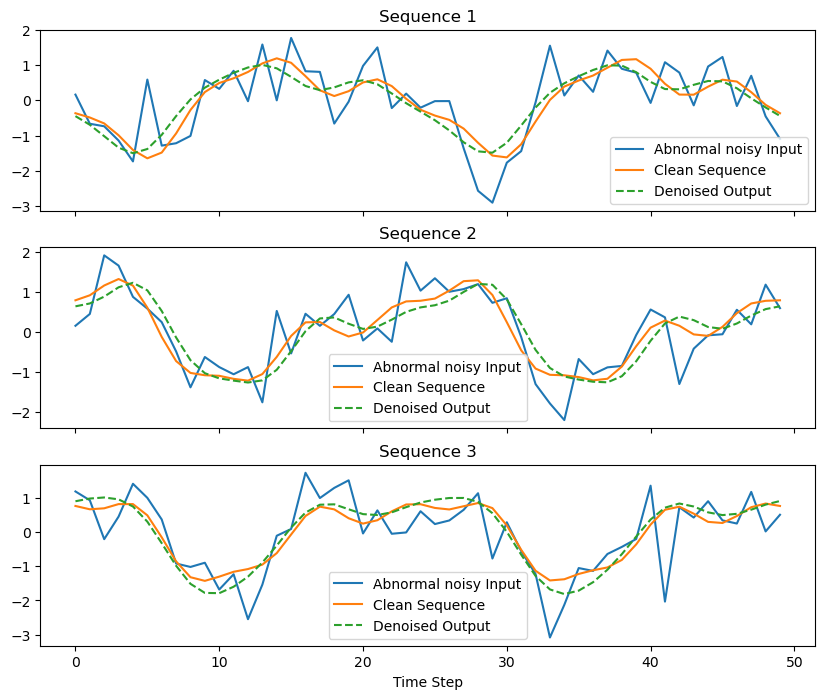

In [3]:
# Step 4: Visualize Results
def visualize_results(model, noisy_data, clean_data):
    model.eval()
    with torch.no_grad():
        test_outputs = model(noisy_data)
    
    fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    for i in range(3):
        axs[i].plot(noisy_data[i].numpy(), label='Abnormal noisy Input')
        axs[i].plot(clean_data[i].numpy(), label='Clean Sequence')
        axs[i].plot(test_outputs[i].numpy(), label='Denoised Output', linestyle='dashed')
        axs[i].legend()
        axs[i].set_title(f'Sequence {i+1}')
    
    plt.xlabel('Time Step')
    plt.show()

# Visualize on test data
visualize_results(model, test_noisy, test_clean)